## Maximizing Earth Observation Satellites (EOS) Utilization with Quantum-Based Scheduling

Earth observation satellites (EOS) play a critical role in a wide range of applications, from environmental monitoring to disaster response, but their effectiveness is often limited by the constraints of traditional scheduling methods. By leveraging the unique properties of quantum computers, it is possible to significantly increase the utilization of EOS.

<table>
    <tr>
        <td>
            <video controls autoplay loop width="640" height="380" src="assets/eos_esa.mp4">
            </video>
        </td>
    </tr>
</table>

<sub>Video Credit: European Space Agency (ESA)</sub>

In [42]:
import random
import pandas as pd
import json
import ast
import xlsxwriter
import seaborn as sns
import neal
import dimod
from dimod import Binary,Real
import numpy as np
from dimod import ConstrainedQuadraticModel,ExactCQMSolver
from dwave.system import LeapHybridCQMSampler
from itertools import chain
import copy
import xlsxwriter
import random
import copy
import time
from pulp import LpVariable, LpProblem, lpSum, LpMaximize, LpMinimize,LpStatus,listSolvers,getSolver
import warnings
warnings.filterwarnings('ignore')

In [5]:
excel_file = 'data/data-eos-20.xlsx'
eos_data_df = pd.read_excel(excel_file)

In [11]:
eos_data_df.head(20)

,Targets,Priorities,Size of Targets,Energies of Targets,Storage Limit of Satellites,Energy Limit of Satellites,Ground Stations,Limit of Ground Stations,Satellite 1,Satellite 2,Satellite 3
0,"['T18', 'T43', 'T10', 'T26', 'T36', 'T11', 'T4...","[30, 3, 9, 26, 14, 10, 29, 27, 2, 11, 24, 18, ...","[36, 20, 28, 14, 15, 16, 24, 12, 26, 18, 9, 22...","[26, 10, 23, 19, 9, 4, 14, 6, 11, 25, 1, 8, 2,...","[296, 318, 391]","[100, 151, 169]","['GS3', 'GS2', 'GS1']","[37, 38, 39]","[27, 25, 'GS1', 'GS2', 10, 'GS3', 37, 15, 35, ...","[40, 24, 30, 21, 43, 23, 11, 13, 32, 38, 37, 4...","[30, 'GS2', 20, 34, 14, 27, 41, 35, 42, 17, 10..."
1,"['T43', 'T42', 'T81', 'T27', 'T16', 'T83', 'T5...","[50, 31, 16, 38, 7, 1, 9, 58, 35, 18, 4, 40, 6...","[40, 47, 36, 17, 28, 69, 71, 27, 58, 46, 12, 6...","[52, 18, 72, 4, 66, 40, 32, 49, 54, 23, 12, 21...","[314, 331, 353]","[147, 207, 255]","['GS6', 'GS1', 'GS3', 'GS5', 'GS2', 'GS4', 'GS7']","[40, 36, 36, 31, 36, 34, 32]","[28, 'GS7', 31, 60, 29, 82, 59, 45, 'GS1', 56,...","[15, 16, 'GS6', 'GS7', 80, 59, 84, 70, 75, 51,...","[84, 78, 37, 25, 17, 39, 14, 42, 18, 83, 70, 7..."
2,"['T11', 'T25', 'T26', 'T31', 'T36', 'T10', 'T1...","[1, 20, 17, 26, 12, 5, 9, 6, 18, 2, 7, 24, 22,...","[6, 10, 4, 23, 14, 5, 16, 20, 13, 27, 15, 11, ...","[15, 4, 9, 25, 2, 24, 7, 10, 12, 20, 14, 3, 19...","[284, 309, 351]","[153, 144, 266]","['GS3', 'GS2', 'GS1']","[31, 33, 34]","[29, 'GS1', 24, 23, 27, 33, 30, 19, 32, 17, 10...","[22, 36, 34, 33, 'GS2', 21, 27, 14, 19, 16, 10...","[13, 'GS3', 'GS1', 'GS2', 14]"
3,"['T95', 'T37', 'T13', 'T16', 'T77', 'T97', 'T1...","[29, 85, 44, 2, 42, 91, 25, 82, 23, 18, 24, 73...","[16, 74, 28, 95, 94, 20, 65, 33, 9, 15, 40, 14...","[21, 42, 26, 47, 51, 86, 72, 87, 93, 23, 74, 5...","[321, 329, 288]","[223, 238, 133]","['GS8', 'GS5', 'GS6', 'GS3', 'GS2', 'GS7', 'GS...","[30, 34, 35, 32, 37, 30, 33, 35]","[42, 75, 81, 29, 'GS5', 'GS2', 63, 87, 62, 94,...","[101, 69, 72, 50, 'GS3', 89, 'GS6', 68, 91, 54...","[33, 31, 39, 80, 41, 36, 42, 'GS5', 15, 88, 94..."
4,"['T10', 'T19', 'T13', 'T15', 'T16', 'T18', 'T1...","[9, 7, 5, 3, 8, 4, 2, 6, 10, 1]","[7, 9, 12, 10, 11, 13, 5, 8, 14, 4]","[6, 2, 1, 5, 9, 7, 4, 8, 10, 3]","[331, 350, 347]","[154, 154, 143]","['GS1', 'GS2', 'GS3']","[38, 39, 27]","[19, 17, 'GS3', 15, 10, 20, 18, 14, 'GS2', 13,...","['GS3', 'GS2', 20, 14, 17, 16, 13, 18, 11, 19,...","[17, 16, 18, 'GS3', 'GS2', 20, 19, 'GS1', 14]"
5,"['T19', 'T79', 'T42', 'T48', 'T25', 'T10', 'T7...","[48, 19, 15, 64, 33, 22, 51, 41, 39, 18, 30, 2...","[64, 10, 11, 41, 47, 14, 73, 46, 44, 29, 53, 1...","[42, 56, 71, 14, 55, 34, 41, 35, 58, 29, 11, 6...","[304, 346, 299]","[183, 121, 108]","['GS5', 'GS3', 'GS1', 'GS4', 'GS6', 'GS2']","[37, 37, 38, 40, 40, 29]","[34, 44, 31, 18, 17, 30, 71, 'GS2', 68, 16, 39...","[37, 64, 15, 'GS4', 30, 60, 34, 'GS2', 77, 47,...","[66, 43, 54, 78, 'GS1', 17, 13, 49, 'GS5', 60,..."
6,"['T48', 'T32', 'T31', 'T41', 'T21', 'T23', 'T2...","[12, 30, 15, 1, 38, 13, 26, 18, 8, 17, 9, 33, ...","[9, 20, 15, 4, 14, 12, 39, 17, 29, 24, 11, 19,...","[17, 12, 27, 4, 2, 28, 19, 8, 9, 21, 35, 7, 24...","[352, 339, 352]","[232, 129, 258]","['GS2', 'GS3', 'GS1', 'GS4']","[28, 28, 27, 36]","[23, 'GS1', 39, 10, 'GS2', 45, 50, 36, 19, 'GS...","[20, 'GS2', 14, 33, 44, 'GS4', 17, 34, 15, 47,...","[38, 'GS2', 14, 'GS4', 43, 'GS1', 'GS2', 15, 10]"
7,"['T31', 'T19', 'T18', 'T33', 'T46', 'T38', 'T1...","[35, 18, 45, 20, 8, 31, 59, 4, 22, 58, 47, 7, ...","[43, 53, 8, 36, 27, 31, 13, 62, 14, 33, 55, 61...","[27, 13, 33, 37, 8, 59, 43, 26, 54, 40, 48, 29...","[291, 392, 344]","[245, 261, 136]","['GS4', 'GS1', 'GS3', 'GS2', 'GS5']","[33, 39, 39, 38, 32]","[56, 67, 28, 27, 10, 63, 33, 23, 20, 50, 52, 6...","['GS4', 61, 15, 45, 55, 18, 60, 10, 56, 21, 39...","[68, 26, 28, 22, 50, 37, 12, 36, 53, 67, 'GS5'..."
8,"['T20', 'T56', 'T61', 'T33', 'T84', 'T63', 'T4...","[14, 20, 73, 66, 45, 72, 6, 54, 59, 41, 58, 39...","[81, 55, 4, 23, 62, 28, 53, 25, 22, 33, 63, 46...","[23, 21, 40, 29, 26, 22, 76, 60, 55, 16, 3

In [24]:
excel_file = 'data/results-eos-20.xlsx'
eos_results_df = pd.read_excel(excel_file)

In [25]:
eos_results_df.head(20)

,Quantum Result,Total Priority (Quantum),Execution Time (Quantum),Satisified all Constraints? (Quantum),UnSatisfied Constraints (Quantum),Simulated Annealing Result,Total Priority (Simulated Annealing),Execution Time (Simulated Annealing),Satisified all Constraints? (Simulated Annealing),Constraints Not Satisfied (Simulated Annealing),Gurobi Optimizer Result,Total Priority (Gurobi Optimizer),Execution Time (Gurobi Optimizer),Satisified all Constraints? (Gurobi Optimizer),Constraints Not Satisfied (Gurobi Optimizer)
0,"[15, 14, 29, 27, 24, 13, 36, 44, 26, 22, 39, 3...",431,9093.718052,True,[],"[14, 16, 27, 25, 35, 33, 10, 25, 22, 33, 21, 2...",277,22.315741,False,['Storage limit not satisfied'],"[15, 14, 29, 27, 24, 21, 36, 44, 18, 26, 39, 3...",430,9329.070807,True,[]
1,"[28, 82, 45, 50, 12, 13, 27, 74, 84, 70, 61, 5...",1097,7889.853477,True,[],"[45, 56, 50, 53, 57, 74, 80, 67, 49, 50, 80, 8...",683,43.413639,False,"['Storage limit not satisfied', 'Energy limit ...","[28, 82, 45, 50, 12, 13, 27, 74, 84, 70, 61, 5...",1154,8427.427292,False,['Storage limit not satisfied']
2,"[16, 26, 25, 23, 30, 32, 17, 10, 20, 22, 36, 1...",262,8018.992186,True,[],"[13, 35, 24, 27, 30, 17, 10, 26, 34, 16, 29, 15]",147,18.931389,True,[],"[16, 25, 23, 30, 19, 17, 10, 28, 20, 26, 22, 3...",254,8153.947592,True,[]
3,"[75, 29, 94, 82, 93, 68, 50, 89, 54, 23, 11, 9...",1342,7839.038849,True,[],"[94, 19, 34, 31, 53, 77, 47, 24]",314,52.808046,False,['Storage limit not satisfied'],"[75, 29, 82, 33, 93, 68, 59, 50, 89, 54, 23, 1...",1358,8622.147560,False,['Storage limit not satisfied']
4,"[10, 20, 15, 13, 11, 19, 14, 17, 16, 18]",55,7946.986675,True,[],"[16, 15, 20, 14, 13, 19]",35,4.778624,True,[],"[17, 10, 15, 13, 11, 14, 16, 18, 20, 19]",55,8031.463385,True,[]
5,"[18, 71, 26, 50, 63, 80, 29, 48, 56, 72, 76, 8...",1091,7867.576599,True,[],"[16, 39, 67, 66, 47, 16, 59, 42, 64, 58, 80]",395,41.549444,False,"['Storage limit not satisfied', 'Energy limit ...","[18, 71, 26, 50, 63, 80, 29, 48, 56, 72, 76, 8...",1091,8456.217289,True,[]
6,"[23, 39, 50, 36, 21, 20, 33, 17, 15, 10, 38, 1...",239,7663.128376,True,[],"[44, 23, 10, 19, 21, 20, 14, 17, 43]",177,10.632038,True,[],"[44, 23, 50, 21, 20, 33, 17, 47, 15, 10, 38, 1...",254,7746.636868,True,[]
7,"[27, 63, 23, 50, 52, 18, 39, 16, 47, 44, 14, 5...",1057,8071.126223,True,[],"[58, 46, 67, 28, 27, 16, 34, 47, 60, 38, 35, 2...",608,36.732435,False,"['Storage limit not satisfied', 'Energy limit ...","[56, 27, 23, 52, 43, 21, 18, 16, 47, 63, 44, 1...",1057,16877.297163,True,[]
8,"[83, 80, 45, 90, 17, 43, 74, 26, 71, 28, 62, 1...",923,8464.317322,True,[],"[80, 56, 27, 18, 45, 37, 50, 49]",262,19.701004,False,['Storage limit not satisfied'],"[83, 80, 45, 87, 90, 43, 74, 26, 71, 81, 28, 6...",874,8717.743874,True,[]
9,"[106, 107, 69, 82, 10, 12, 103, 51, 96, 25, 85...",982,7789.160967,True,[],"[106, 78, 45, 11, 43, 56, 66, 49, 15, 102, 67,...",365,26.545763,False,"['Storage limit not satisfied', 'Energy limit ...","[106, 107, 69, 82, 10, 12, 103, 51, 96, 25, 85...",982,7972.399712,True,[]


In [26]:
eos_results_df.describe()

,Total Priority (Quantum),Execution Time (Quantum),Total Priority (Simulated Annealing),Execution Time (Simulated Annealing),Total Priority (Gurobi Optimizer),Execution Time (Gurobi Optimizer)
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,701.450000,8015.087175,311.900000,26.271224,698.650000,8809.948134
std,383.176677,455.743103,155.755848,14.996217,383.948088,1997.659466
min,55.000000,7250.904083,35.000000,4.778624,55.000000,7402.764797
25%,413.500000,7791.315496,249.000000,16.284466,412.750000,7969.767988
50%,728.500000,7920.350432,285.000000,21.419525,712.000000,8201.330304
75%,1027.750000,8143.395483,382.250000,36.561131,1000.750000,8838.168740
max,1342.000000,9093.718052,683.000000,58.427811,1358.000000,16877.297163


Quantum Results:


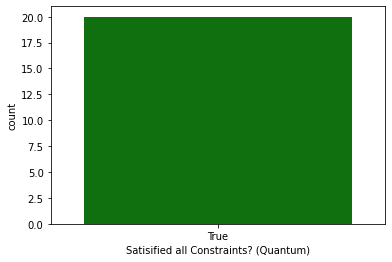

In [56]:
print('Quantum Results:')
eos_results_df["Satisified all Constraints? (Quantum)"].value_counts()
sns.countplot(eos_results_df['Satisified all Constraints? (Quantum)'], palette=['g']);

Simulated Annealing Results:


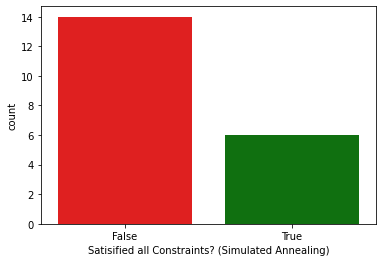

In [54]:
print('Simulated Annealing Results:')
eos_results_df["Satisified all Constraints? (Simulated Annealing)"].value_counts()
sns.countplot(eos_results_df['Satisified all Constraints? (Simulated Annealing)'], palette=['r', 'g']);

Gurobi Optimizer Results:


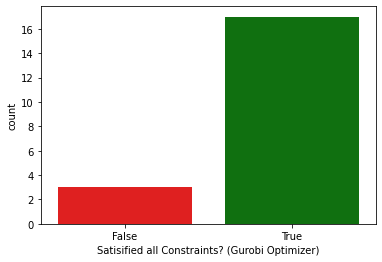

In [57]:
print('Gurobi Optimizer Results:')
eos_results_df["Satisified all Constraints? (Gurobi Optimizer)"].value_counts()
sns.countplot(eos_results_df['Satisified all Constraints? (Gurobi Optimizer)'], palette=['r', 'g']);

In [9]:
input_json_array = []
for index, row in eos_data_df.iterrows():
    input_json_array.append({'Targets': row['Targets'], 'Priorities': row['Priorities'],
                             'Size of Targets': row['Size of Targets'], 
                             'Energies of Targets': row['Energies of Targets'],
                             'Storage Limit of Satellites': row['Storage Limit of Satellites'], 
                             'Energy Limit of Satellites': row['Energy Limit of Satellites'],
                             'Ground Stations': row['Ground Stations'], 
                             'Limit of Ground Stations': row['Limit of Ground Stations'],
                             'Satellite 1': row['Satellite 1'], 'Satellite 2': row['Satellite 2'],
                             'Satellite 3': row['Satellite 3']                            
                            })
input_json = json.dumps(input_json_array)